## Options structural break detection with N-beats

### Equity options

In [1]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint
import pickle

In [2]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import NBeats, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, MAPE, MASE, SMAPE

# Load TensorBoard notebook extension
%load_ext tensorboard

# allow Matplotlib plots display within notebook 
%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from time_series_utils import get_nth_train_split

Importing plotly failed. Interactive plots will not work.


In [5]:
from time_series_nbeats_utils import preprocess_nbeats, nbeats_modeler, compute_mape, return_nbeats_predictions

## Cboe Options Historical Volume and Put/Call Ratios

### Equity options 

In [6]:
from datetime import datetime
dateparser = lambda x: datetime.strptime(x, '%m/%d/%Y')

In [7]:
with open('IDX_options.pkl', 'rb') as f:
    df1_eqt = pickle.load(f)

We need to add the group column. set to same group id.

In [8]:
df1_eqt.head()

PutCall_Ratio_Total
Date                           
2006-11-06            573452.46
2006-11-07            631694.96
2006-11-08            532944.72
2006-11-09            630284.04
2006-11-10            437933.40

In [9]:
df1_eqt = preprocess_nbeats(df1_eqt)

In [10]:
df1_eqt1 = df1_eqt[:'2013-01-01']
df1_eqt1

PutCall_Ratio_Total  group  time_idx
Date                                            
2006-11-06         5.734525e+05      1         0
2006-11-07         6.316950e+05      1         1
2006-11-08         5.329447e+05      1         2
2006-11-09         6.302840e+05      1         3
2006-11-10         4.379334e+05      1         4
...                         ...    ...       ...
2012-12-28         1.627133e+06      1      2244
2012-12-29         1.632082e+06      1      2245
2012-12-30         1.637030e+06      1      2246
2012-12-31         1.641978e+06      1      2247
2013-01-01         2.094819e+06      1      2248

[2249 rows x 3 columns]

<AxesSubplot:xlabel='Date'>

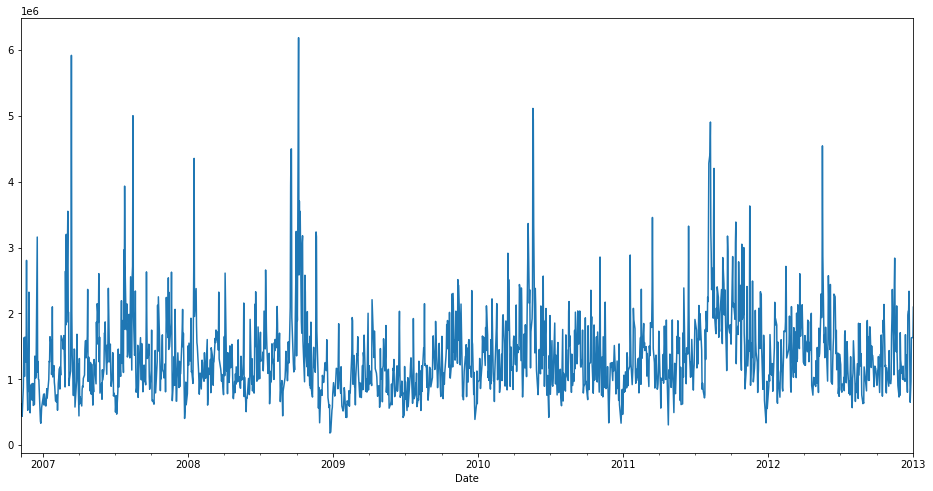

In [11]:
df1_eqt1['PutCall_Ratio_Total'].plot(figsize=(16,8))

Preprocess data for N-beats 

In [12]:
df1_eqt1.describe()

PutCall_Ratio_Total   group     time_idx
count         2.249000e+03  2249.0  2249.000000
mean          1.334155e+06     1.0  1124.000000
std           6.066824e+05     0.0   649.374699
min           1.845736e+05     1.0     0.000000
25%           9.386146e+05     1.0   562.000000
50%           1.210359e+06     1.0  1124.000000
75%           1.597933e+06     1.0  1686.000000
max           6.184402e+06     1.0  2248.000000

In [13]:
training_df, validation_df, test_df = get_nth_train_split(df1_eqt1, 0, train_week_len=14)

In [14]:
model, trainer, train_dataloader, val_dataloader, test_dataloader = nbeats_modeler(training_df, validation_df, test_df, max_encoder_length=13*7)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
len(training_df)

98

In [16]:
training_df.columns

Index(['PutCall_Ratio_Total', 'group', 'time_idx'], dtype='object')

In [17]:
model

NBeats(
  (loss): MAPE()
  (logging_metrics): ModuleList(
    (0): MAPE()
  )
  (net_blocks): ModuleList(
    (0): NBEATSTrendBlock(
      (fc): Sequential(
        (0): Linear(in_features=91, out_features=32, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (3): ReLU()
        (4): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (5): ReLU()
      )
      (theta_f_fc): Linear(in_features=32, out_features=3, bias=False)
      (theta_b_fc): Linear(in_features=32, out_features=3, bias=False)
    )
    (1): NBEATSSeasonalBlock(
      (fc): Sequential(
        (0): Linear(in_features=91, out_features=512, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=512, out_features=512, bias=

In [18]:
%tensorboard --logdir training_logs

Reusing TensorBoard on port 6006 (pid 31340), started 6 days, 22:48:45 ago. (Use '!kill 31340' to kill it.)

In [19]:
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MAPE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 581 K 
-----------------------------------------------
581 K     Trainable params
0         Non-trainable params
581 K     Total params
2.325     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

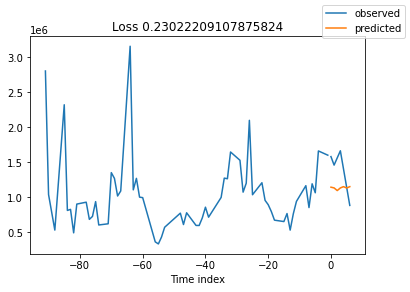

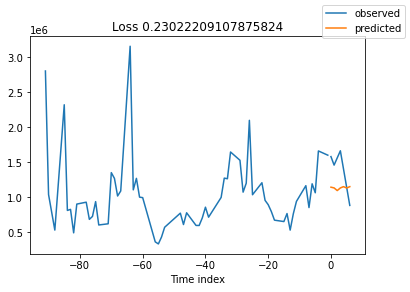

In [20]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

raw_predictions, x = best_model.predict(test_dataloader, mode="raw", return_x=True)

best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)

In [ ]:
%%capture 

mape_list = []
steps = 156  # number of windowing stteps (unit week)

pred_df = None

for i in range(steps):
    training_df, validation_df, test_df = get_nth_train_split(df1_eqt1, i, train_week_len=14)
 
    model, trainer, train_dataloader, val_dataloader, test_dataloader = nbeats_modeler(training_df, validation_df,\
                                                                                       test_df, max_encoder_length=13*7)

    # fine tune learning rate hyperparameter
    res = trainer.tuner.lr_find(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,\
                                min_lr=1e-5)
    print(f"suggested learning rate: {res.suggestion()}")
    model.hparams.learning_rate = res.suggestion()

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    nbeats_test_df = return_nbeats_predictions(trainer, test_dataloader, test_df)

    if i == 0:
        pred_df = nbeats_test_df['nbeats_pred']
    else:
        pred_df = pd.concat([pred_df, nbeats_test_df['nbeats_pred']])
    mape = compute_mape(training_df, nbeats_test_df, 'value', 'nbeats_pred')
    mape_list.append((mape, (test_df.index[0], test_df.index[-1])))

print(f"The MAPE for each of the windowing steps is : {mape_list}")
print("")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LR finder stopped early after 50 steps due to diverging loss.
Restoring states from the checkpoint path at C:\Users\wismi\workspace\final_project\structural_break_down\.lr_find_ae9266dd-8d6e-403e-aa10-51272f272dcd.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MAPE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 581 K 
-----------------------------------------------
581 K     Trainable params
0         Non-trainable params
581 K     Total params
2.325     Total estimated model params size (MB)
Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU 

In [ ]:
mape_list

In [ ]:
sum(map(lambda x: x[0], mape_list))/len(mape_list)

In [ ]:
!nvidia-smi -L

In [ ]:
import pickle

with open("n_beats_interval_14_IDX_mapes_156weeks.pkl", "wb") as f:
    pickle.dump(mape_list, f)

In [ ]:
with open('n_beats_interval_14w_IDX_pred_2007-2009.pkl', 'wb') as f:
    pickle.dump(pred_df, f)